In this notebook we will show practical ways to find the corners and key points in an image; we will find lines in the image using the same method that is used in Tesla autopilots; we will see how to compare the images automatically, for example, for object recognition, panorama creation, affine image transformations reconstruction, etc.


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
from PIL import Image
mpl.rcParams['figure.dpi'] = 200

**Harris detector**



Let's learn how to use Harris detector in Python. First, let's read the original image and display it on the screen.

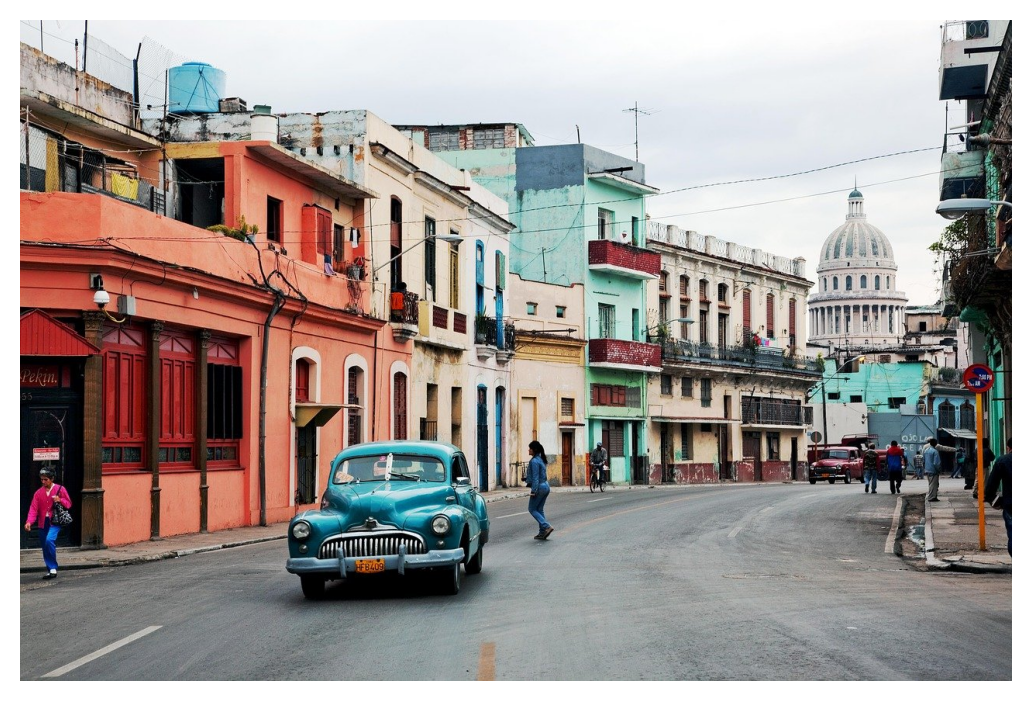

In [41]:
img = cv2.imread('cuba-1638594_1280.jpg')
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

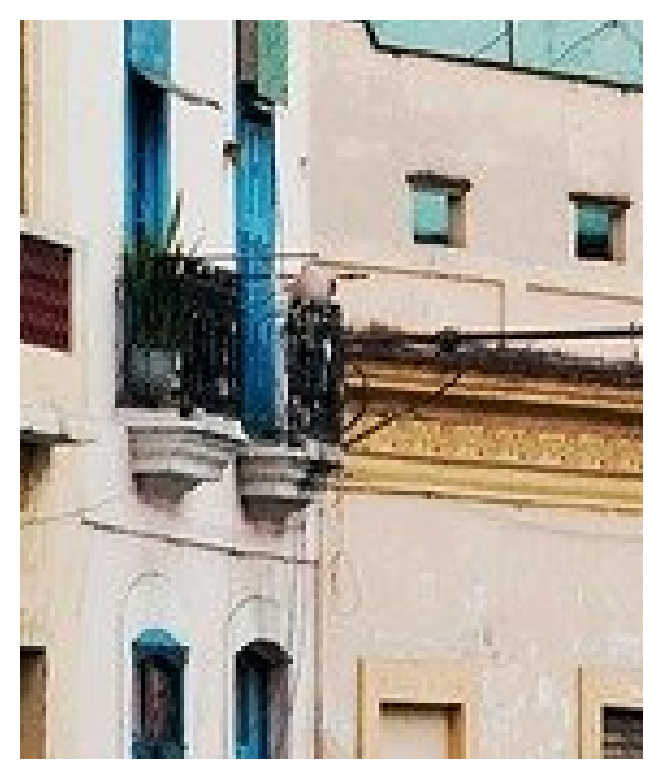

In [42]:
img2 = img[329:500, 564:708]
plt.axis('off')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [43]:
img2.shape

(171, 144, 3)

Let's transform our image to grayscale and replace integer values to real ones of the type float32 - these are the requirements for the further usage of the Harris detector function.

In [3]:
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img1 = np.float32(img1)

Now let's use cv2.cornerHarris(image,blockSize,ksize,k) function, where 

'image' is an image (black-and-white and of type float32)

blockSize is the neighborhood size (i.e. for each pixel the block of size blockSize*blockSize is considered)

ksize is the Sobel kernel size, which is used in cv2 for derivatives computation with respect to horizontal axis Ix and vertical axis Iy in each point of the image.
The parameter ksize can take the values 3, 5, 7 etc. (3x3, 5x5, ...). With the increasing size, the more and more pixels take part in the convolution process, and the edges become more blurry.

k is an empirical constant, normally taking the values in the range 0.04 - 0.06. With a greater k you obtain less false corners, but miss more true corners (high precision), with a smaller k, you will obtain far more corners, i.e. miss less true corners, but obtain many false corners (high recall).

Let's take a look at the image obtained:

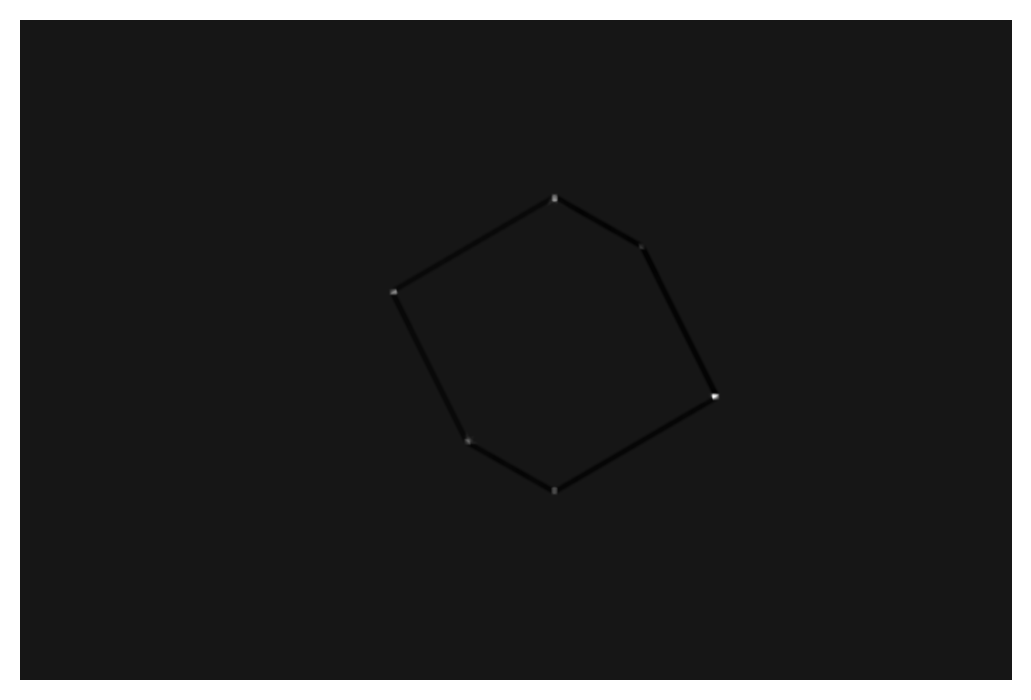

In [4]:
dst = cv2.cornerHarris(img1,10,3,0.04)
plt.axis('off')
plt.imshow(dst, cmap='gray')

The result of the cv2.cornerHarris function exectution is a set of the same size as the original image, where the probabilities of the potential corners are stored. 

Let's stretch our result using cv2.dilate function in order to extend the light regions, and let's take a look at the result obtained (the "edge points map"):

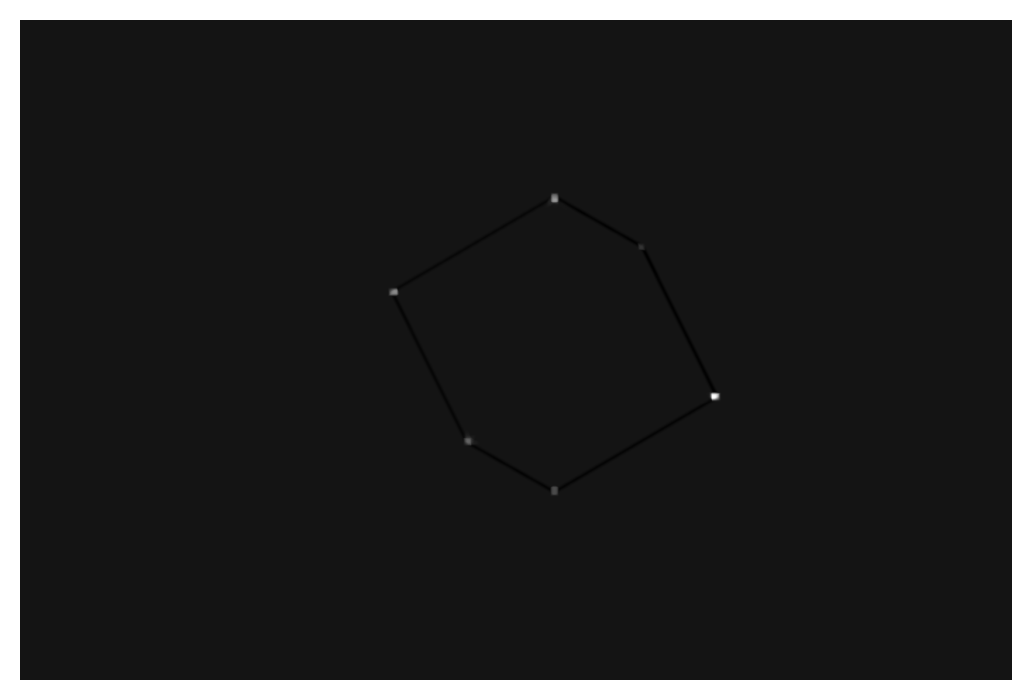

In [5]:
dst = cv2.dilate(dst,None)
plt.axis('off')
plt.imshow(dst, cmap='gray')

It remains to remove values less than a certain threshold and place the resulting edge map onto our original image.

Threshold is usually defined as the maximum value multiplied by a coefficient less than unity. All the pixels less than a threshold will remain in their original view, and the pixels with values that are greater than a threshold can be painted in a certain color.

The coefficient for determining the threshold depends on the original image (the smaller this coefficient, the more "potential" corners we will see). Now we will set it to 0.01 (we will choose the pixels with a probability that differs from max no more than for 1%), but we recommend you to try other values as well.


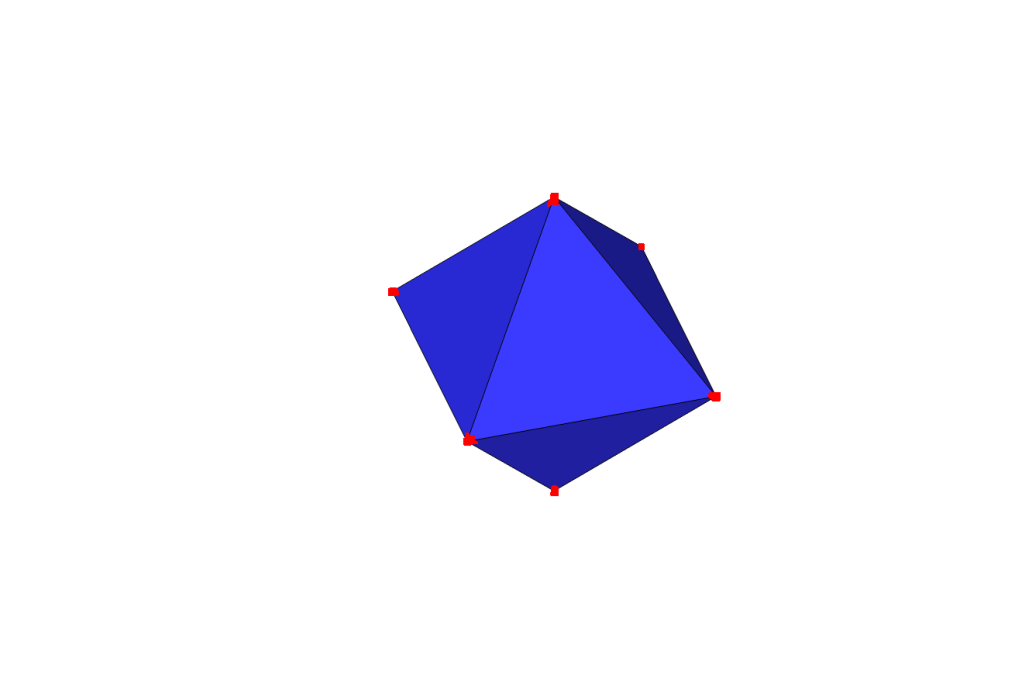

In [6]:
threshold = 0.01*dst.max()
img[dst>threshold]=[255,0,0] 
#[255,0,0] - highlight corner regions with blue, [0,255,0] - with green, [0,0,255] - with red,
#[0,0,0] - with black, [255,255,255] - with white
plt.axis('off')
plt.imshow(img, cmap='gray')

We suggest you to check yourself that the Harris method is invariant with respect to rotation and not invariant with respect to scaling. To do this, you need to change the original image using, for example, the following functions cv2.flip(img, -1) (0 - rotate with respect to РҐ axis, 1 to Y, -1 to X and Y) or cv2.resize(img, (width_new, high_new))

**Shi-Tomasi Detector**

This detector is very similar to the Harris detector, but differs in the calculation of the response measure: the algorithm directly calculates the value, since it is assumed that the it makes the corner retrieval more stable.

Let's consider how to use the Shi Thomas detector by Python. 

Let's read the original image and transform is to black and white.

In [8]:
img = cv2.imread('test.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

Let's apply cv2.goodFeaturesToTrack(image,maxCorners, qualityLevel, minDistance) function, where

image id an image (black-and-white)

maxCorners is the maximum number of corners to search for (if there are less corners, than the function will be applied to the "strongest" corners)

qualityLevel is the quality is the quaility level characterized by the minimum corner quality in the image (0-1)

minDistance is the minimum distance between the corners




C:\Users\Ivan\AppData\Local\Temp\ipykernel_20780\2379764823.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners) # transform to integers


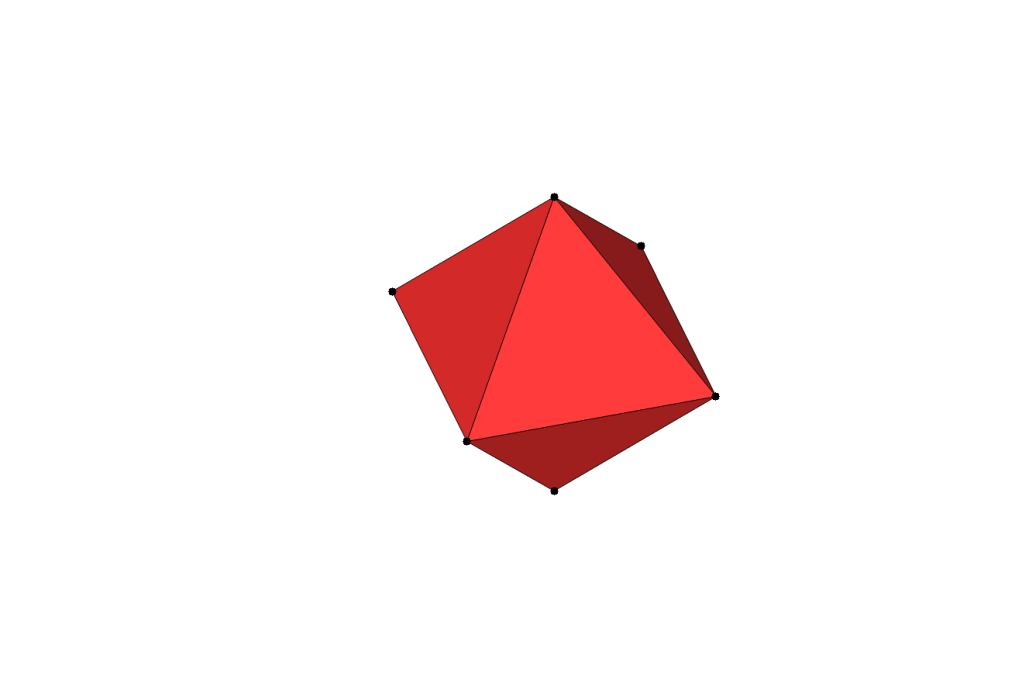

In [9]:
corners = cv2.goodFeaturesToTrack(gray, 6, 0.01, 5)
corners = np.int0(corners) # transform to integers
for i in corners:
    x, y = i.ravel() # find corner coordinates
    cv2.circle(img, (x, y), 5, [0,0,0], -1) # draw a circle in the original image, at the specified point, 
                                        # of the specified radius (5), and color with the specified filling (-1)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**Hough Transform**

This method is used to find lines and curves in the images. It's used in Tesla autopilots.

Let's upload the image and transform it to the grayscale:



In [10]:
mpl.rcParams['figure.dpi'] = 100

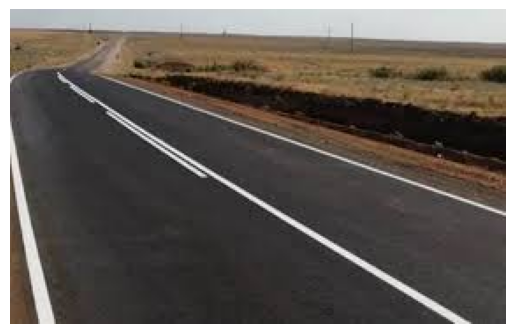

In [12]:
img = cv2.imread("road.jpeg")
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Let's find the image edges using cv2.Canny(image, threshold1, threshold2) function, having the following arguments:

image is the original image (black-and-white)

threshold1 is the upper threshold of the intensity gradient,

threshold2 is the lower threshold of the intensity gradient.

As you can guess from its name, this function uses Canny edge detector.  



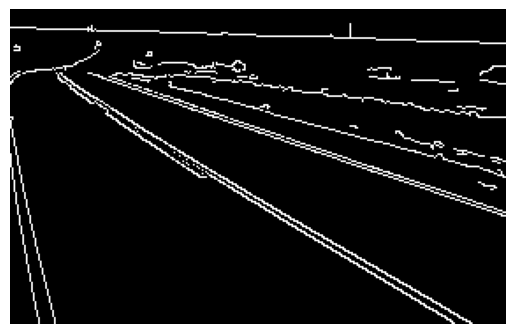

In [14]:
edges = cv2.Canny(gray, 150, 300)
plt.axis('off')
plt.imshow(edges, cmap='gray')

You can try different the threshold values yourself. For example, take the average pixel intensity of an image (v = np. median (gray)) and calculate the deviations from it with some empirical coefficient equal to
0.33 using the formulas: threshold1 = int(max(0, (1.0 - 0.33) * v))
threshold2 = int(min(255, (1.0 + 0.33) * v))

Now let's use cv2.HoughLinesP() function for line detection. We will use the following arguments: image edges, maxLineGap - maximum distance between the lines, 
minLineLength - mimimum line length, rho and theta are the resolutions in pixels and radians, respectively.
Let's draw the obtained lines:

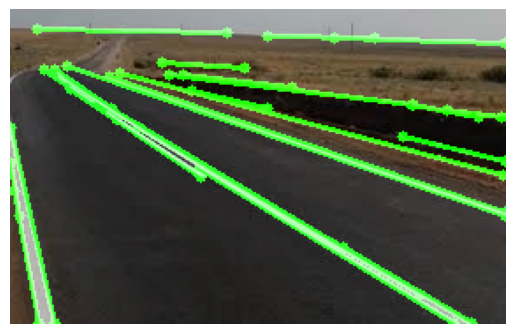

In [15]:
lines = cv2.HoughLinesP(edges, rho=1.0,theta=np.pi/180,threshold=20,minLineLength=30,maxLineGap=10)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) #creating an empty iamge with the same length, height and color model as img has
line_color = [0, 255, 0]
line_thickness = 2
dot_color = [0, 255, 0]
dot_size = 3

for line in lines: #the cycle gives the segments
    for x1, y1, x2, y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.circle(line_img, (x1, y1), dot_size, dot_color, -1)
        cv2.circle(line_img, (x2, y2), dot_size, dot_color, -1)
final = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) 
#we superimpose the image with segments onto the original image
# 0.8 - alpha(specifies the weight of the first image)
# 1.0 - beta(specifies the weight of the second image)
# 0.0 - gamma(a scalar value that is added to each image)
# Р¤РѕСЂРјСѓР»Р° addWeighted: final = img*alpha + line_iplt.axis('off')
plt.axis('off')
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

**SIFT Descriptor (Scale-Invariant Feature Transform)**

We upload the original image as GRAYSCALE:

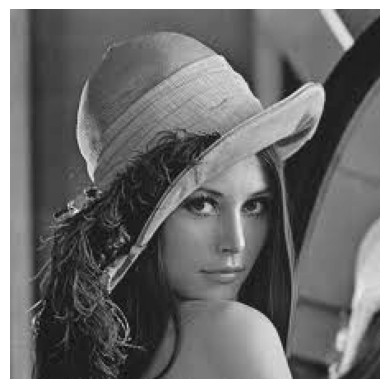

In [17]:
img = cv2.imread('Lena.jpg', cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(img, cmap='gray')

Let's make the object-algorithm SIFT and find keypoints using sift.detectAndCompute(img).

Each keypoint is a structure having plenty of attributes, such as (x, y) coordinates, relevant neighborhood size, angle that defines its orientation, key points strength etc. 

A descriptor is a some set of values used for keypoints search based on the intensity, size and orientation, it stores the histogram of oriented gradients for the neighborhood of each keypoint.

Let's display the attribute values for some keypoints that are going to be useful in the future.

In [19]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img, None)
for i in range(0,3):
  print("SIFT Keypoint:",i)
  print("Coordinates ",kp[i].pt,"Size ", kp[i].size, "Angle ", kp[i].angle)


SIFT Keypoint: 0
Coordinates  (15.591696739196777, 182.9761505126953) Size  2.3962228298187256 Angle  217.6338653564453
SIFT Keypoint: 1
Coordinates  (16.123144149780273, 153.87867736816406) Size  5.678529739379883 Angle  179.068359375
SIFT Keypoint: 2
Coordinates  (16.41448402404785, 207.24119567871094) Size  2.287032127380371 Angle  174.12124633789062



Let's use the built-in cv2.drawKeyPoints() function, that draws circles around a found keypoint. The parameters of this function are the following: our image, keypoints set, color, flags (not mandatory) in case we would like the circle to have the size and the direction of the keypoint (as we know, the direction of the keypoint is defined based on the gradients direction of the neighboring points)

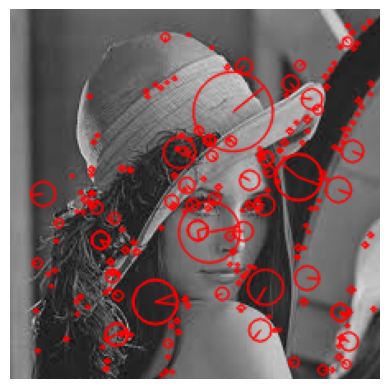

In [20]:
img_kp = cv2.drawKeypoints(img,kp,np.array([]),[255,0,0],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.axis('off')
plt.imshow(img_kp, cmap='gray')

Let's use SIFT descriptor to find one image in the other. For example, let's find a specific license plate in the traffic. Let's make the task more difficult - and flip the plate.

Let's upload the image and trasform it to the grayscale:

In [49]:
img1 = cv2.imread("cuba-1638594_1280.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = img[329:500, 564:708]
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

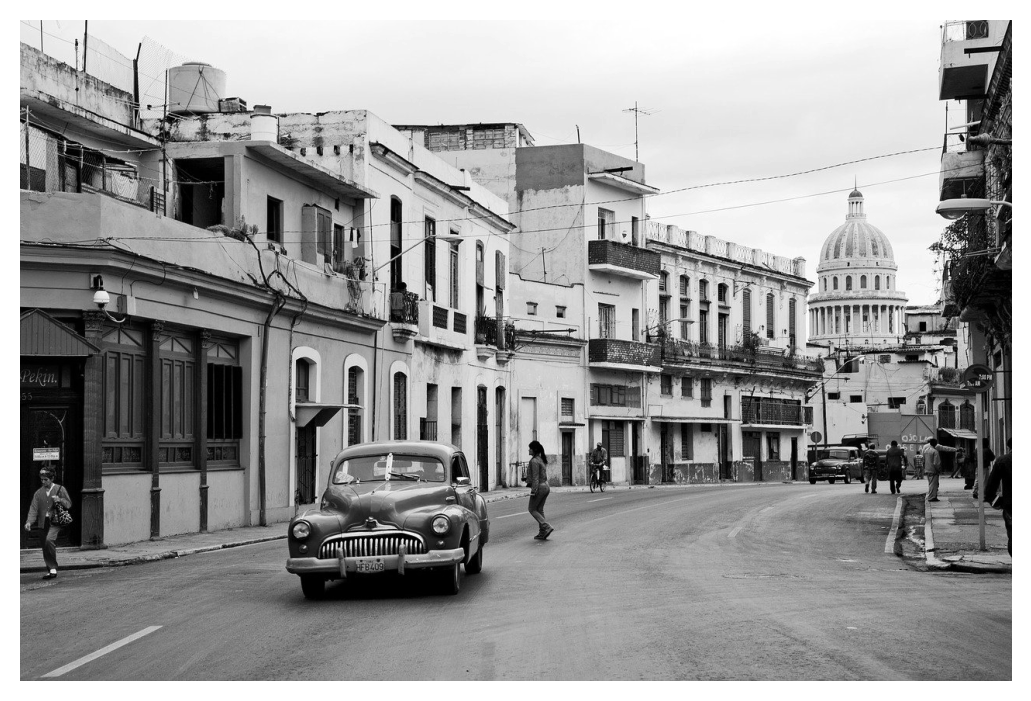

In [50]:
plt.axis('off')
plt.imshow(img1, cmap='gray')

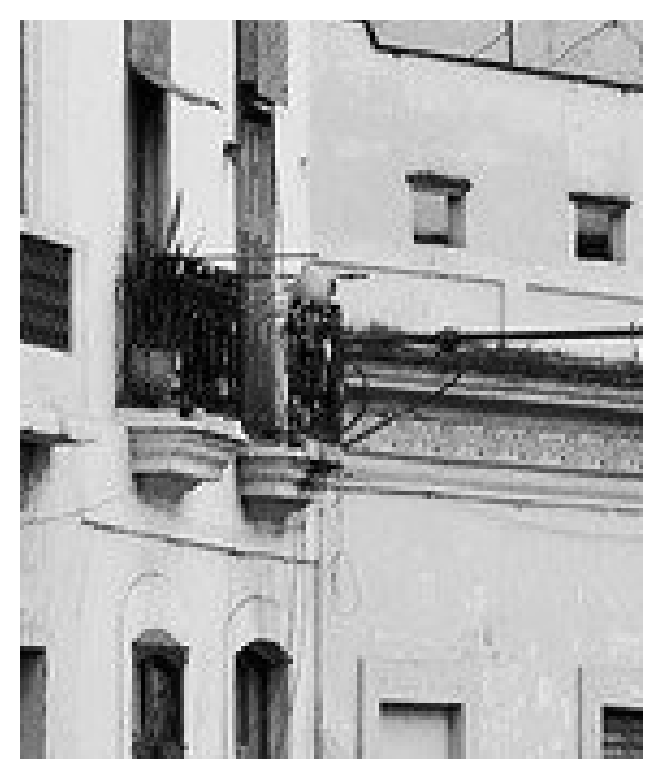

In [51]:
plt.axis('off')
plt.imshow(img2, cmap='gray')

Using SIFT descriptor. Let's find keypoints and descriptors:

In [52]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) 
kp2, des2 = sift.detectAndCompute(img2, None) 

We need to compare the keypoints and the corresponding descriptors of one image with the other. We can use BFMatcher for that (Brute-force matcher):

In [53]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=True) 
#crossCheck=false - one-to-many match, crossCheck=true - one-to-one match
matches = bf.match(des1,des2)

The ontained matches have the following attributes: distance (in fact, this is the distance between two vectors, and in our case it is the Euclidean distance), index corresponding to the first image, index corresponding to the second image.

Let's sort the matches from the best to the worst according to the distance attribute (the less is the distance, the better).

In [71]:
img1 = cv2.imread("cuba-1638594_1280.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [80]:
img2 = img[329:500, 564:708]

In [82]:
img2[97,10]

array([18, 34, 46], dtype=uint8)

In [83]:
img1[426,574]

array([46, 34, 18], dtype=uint8)

In [73]:
x1, y1 = kp1[2370].pt

In [77]:
x2, y2 = kp2[5].pt

In [78]:
x2

9.8652982711792

In [79]:
y2

96.85367584228516

In [74]:
x1

573.8652954101562

In [ ]:
574, 426

In [75]:
y1

425.8536682128906

In [61]:
matches = sorted(matches, key = lambda x:x.distance) 
print('Matches rate ', len(matches))
for i in range(0,20): #let's display the first 3 
  print('Distance ',matches[i].distance,'Index 1 ',matches[i].trainIdx,'Index 2 ', matches[i].queryIdx)

Matches rate  150
Distance  0.0 Index 1  5 Index 2  2370
Distance  0.0 Index 1  8 Index 2  2416
Distance  0.0 Index 1  10 Index 2  2432
Distance  0.0 Index 1  11 Index 2  2436
Distance  0.0 Index 1  12 Index 2  2442
Distance  0.0 Index 1  13 Index 2  2443
Distance  0.0 Index 1  16 Index 2  2449
Distance  0.0 Index 1  17 Index 2  2452
Distance  0.0 Index 1  22 Index 2  2456
Distance  0.0 Index 1  26 Index 2  2468
Distance  0.0 Index 1  27 Index 2  2469
Distance  0.0 Index 1  28 Index 2  2475
Distance  0.0 Index 1  29 Index 2  2476
Distance  0.0 Index 1  30 Index 2  2480
Distance  0.0 Index 1  31 Index 2  2481
Distance  0.0 Index 1  32 Index 2  2485
Distance  0.0 Index 1  33 Index 2  2486
Distance  0.0 Index 1  35 Index 2  2491
Distance  0.0 Index 1  37 Index 2  2494
Distance  0.0 Index 1  41 Index 2  2505


Let's dipslay the obtained result for the best 5 matches using cv2.drawMatches function, where we specify the original images, keypoints (at this step we can turn to the original color images back).

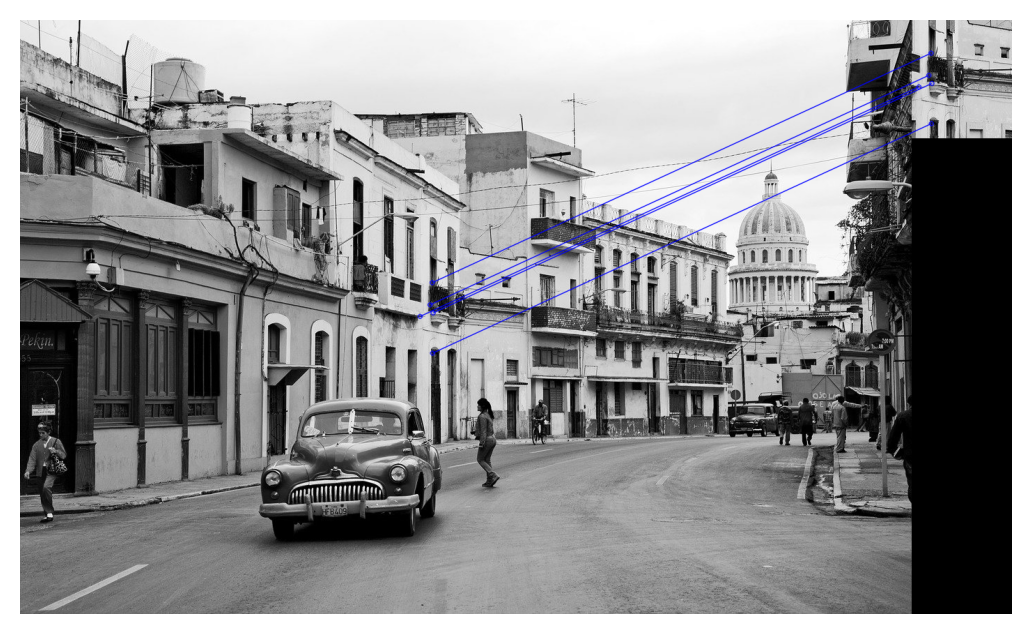

In [56]:
matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:5], None, [255,0,0], flags=2)
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

And now let's try to compare two images using SIFT descriptor.

Let's upload the images and transform them to the grayscale:

In [31]:
img_1 = cv2.imread("tt_2.jpg")
img_2 = cv2.imread("tt_1.jpg")
img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

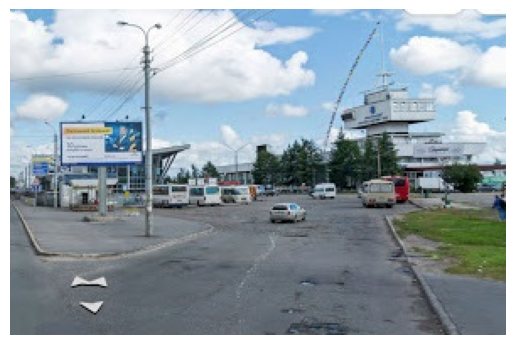

In [32]:
mpl.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

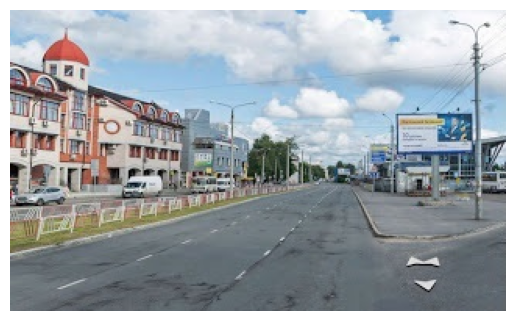

In [33]:
plt.axis('off')
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))

Using SIFT descriptor let's find the keypoints and the descriptors:

In [35]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) 
kp2, des2 = sift.detectAndCompute(img2, None) 

We need to compare the keypoints and the corresponding desciptors of two images. We will use BFMatcher (Brute-force matcher) to do it:

In [36]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=True) 
#crossCheck=false - one-to-many matches, crossCheck=true - one-to-one matches
matches = bf.match(des1,des2)

Let's sort the matches from the best to the worst according to the distance attribute (the less is the distance, the better), in fact, this is the distance between two vectors.

In [37]:
matches = sorted(matches, key = lambda x:x.distance) 
print('Matches rate ', len(matches))
for i in range(0,3): #let's display first  3 
  print('Distance ',matches[i].distance,'Index 1 ',matches[i].trainIdx,'Index 2 ', matches[i].queryIdx)


Matches rate  166
Distance  17.0 Index 1  405 Index 2  80
Distance  17.0 Index 1  419 Index 2  94
Distance  19.0 Index 1  391 Index 2  63


Let's see the best matches we obtained (the first 99):

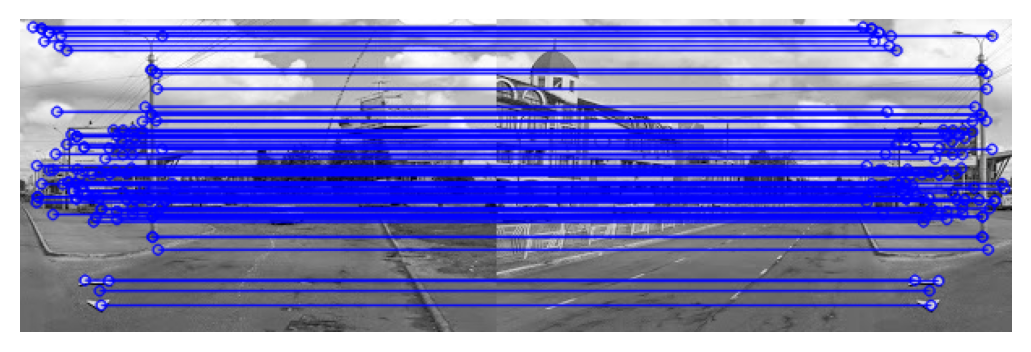

In [38]:
matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:99], None,[255,0,0], flags=2)
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

Now let's try to define a transformation matrix that transposes a set of key points and their descriptors of one image into a similar set of the other image. 

Let's create new sets of real float32 type, in which we change the coordinates of the keypoints (we use the keypoints coordinates of the second image as the keypoint coordinates of the first image and vice versa). But we will make this only for matched keypoints, i.e. the keypoints present in the matches list.

And we will find the transformation matrix H using the RANSAC algorithm (described in detail in the lecture) and the cv2.findHomography function, which we will just feed our new sets to.

In [39]:
new1 = np.float32([kp1[m.queryIdx].pt for m in matches]) # the coordinates of the keypoint of the 1st image
new2 = np.float32([kp2[m.trainIdx].pt for m in matches]) # the coordinates of the keypoint of the 2nd image
H, status = cv2.findHomography(new1, new2, cv2.RANSAC, 4.0)

Now, everything is ready to obatin the resulting image. We expect the first image to shift to the right, and the second one to overlap it shifting to the left.

Let's make this: apply our transformation matrix to the first one, and superimpose the second one on top.

We will not concentrate on calculating the size of the resulting image. Roughly, let's assume that it will be clearly less in width than the sum of the original ones (they must overlap with the shift), and no more in height than the maximum height of the two original ones.

Note that in the last step, we will use the original images (not in grayscale).

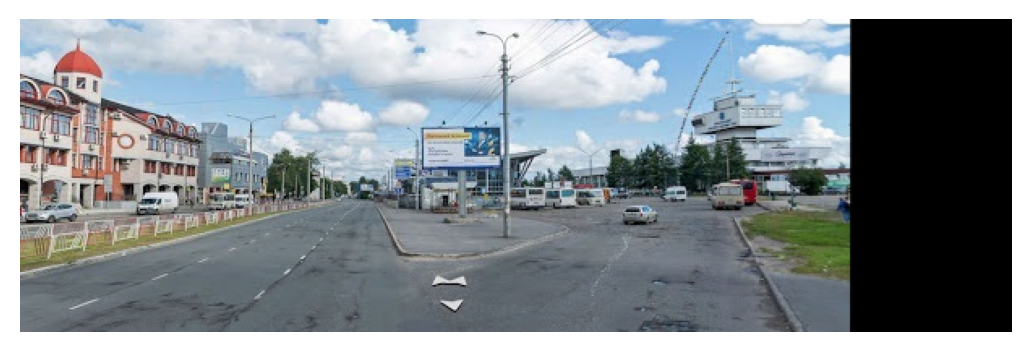

In [40]:
width = img1.shape[1] + img2.shape[1] 
height = max(img1.shape[0],img2.shape[0])
result = cv2.warpPerspective(img_1, H, (width,height)) #Transform the 1st image
result[0:img2.shape[0], 0:img2.shape[1]] = img_2      #Superimpose the 2nd image in the left corner
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

We obtained the expected result (the black region appeared becouse of the rough estimation of the sizes).